Problem statement
===============

Want to write code that can generate a parametric wing geometry, and then perform a lifting line analysis on that geometry to understand the loading on it.

Classes:
- LiftingSurface:
    - Generates wing coords and lifting line geometry
    - 2D/3D plots of wing
    - Compute area, AR, simple lift
- Aerofoil
    - Takes in coordinates and computes polars
    - Interpolates polars at certain aoa
- VortexLine
    - Instantiates and stores info about each vortex
- FoilAssembly:
    - Assembles multiple LiftingSurfaces into a FoilAssembly i.e. assembles local wing coords into global system
    - Plot assembly


Functions:
- Steady LL solve w.r.t to some pseudo-time until no change in circulation
    - Compute circulation
    - Convect wake   
- Extract and print forces

---------

<!-- Functions required
- Plot 2D and 3D geometry
- Convert parametric geometry to lifting lines
- Compute aero polars (Cl, Cd, Cm)
- Lifting line code
    - Compute circulation
    - Convect wake
    - Note surface effect dealt with by mirroring bound and wave vortices about the water surface plane
- Extract forces

--------- -->

Input geometry
=

Input geometry parameters:
- Root chord
- Tip chord
- Span
- Aerofoil coordinates?
- Sweep parameters = tip sweep and curvature coefficient
- Dihedral parameters = vertical tip distance and curvature coefficient
<!-- - Twist -->

Geometry outputs:
- Aspect ratio
- Projected area
- Actual surface area
- Lift, as a function of speed (m/s), aoa (deg), and rho (kg/m^3)




In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import pchip_interpolate
from scipy.interpolate import interp1d 
import math
from mpl_toolkits import mplot3d

In [62]:
# import sys
# !{sys.executable} -m pip install xfoil

In [425]:
class LiftingSurface:
    
    def __init__(self, rt_chord, tip_chord, span, sweep_tip=0, sweep_curv=0, dih_tip=0, dih_curve=0):
        self.rt_chord = rt_chord
        self.tip_chord = tip_chord
        self.span = span
        self.sweep_tip = sweep_tip
        self.sweep_curv = sweep_curv
        self.dih_tip = dih_tip
        self.dih_curve = dih_curve
        
    def generate_coords(self, npts = 1001):
        self.x = np.linspace(-self.span/2, self.span/2, npts).reshape(npts, 1)
        sweep_curv = self.sweep_tip*(2*np.abs(self.x)/self.span)**self.sweep_curv
        dihedral_curv = self.dih_tip*(2*np.abs(self.x)/self.span)**self.dih_curve
        
        self.ref_axis = np.hstack((self.x, sweep_curv, dihedral_curv))
        
        self.f_chord = interp1d(np.array([-self.span/2, 0, self.span/2]), 
                         np.array([self.tip_chord, self.rt_chord, self.tip_chord]))
        chord = self.f_chord(self.x)
        
        dist_LE_2_refAxis = 0.5
        
        self.LE = np.hstack((self.x, 
                             self.ref_axis[:,1].reshape(npts, 1) + dist_LE_2_refAxis * chord, 
                             dihedral_curv))
        self.TE = np.hstack((self.x, 
                             self.ref_axis[:,1].reshape(npts, 1) - (1 - dist_LE_2_refAxis) * chord, 
                             dihedral_curv)) 
        
        self.qu_chord_loc = 0.75*self.LE + 0.25*self.TE
        
#         mid_tip = 0.5 * (self.LE[0,-1] + self.TE[0,-1])
#         tip_smoothing_param = 0.8
#         x_id = int(tip_smoothing_param*npts) 
#         mask = np.hstack((np.arange(0, x_id) , npts-1))
#         x_in = self.x[0, mask]
#         LE_in = np.hstack((self.LE[0, mask[0:-1]], self.LE[0, -1] - (1-tip_smoothing_param) * self.tip_chord))
#         LE_new = pchip_interpolate(x_in, LE_in, self.x)
#         print(LE_new)
        
    def plot2D(self):
        x_coords = np.hstack((self.LE[:,0], np.flip(self.LE[:,0]), self.LE[0,0]))
        y_coords = np.hstack((self.LE[:,1], np.flip(self.TE[:,1]), self.LE[0,1]))
        
        plt.plot(x_coords, y_coords, 'k-') # plot external planform
        
        plt.plot(self.ref_axis[:,0], self.ref_axis[:,1], 'm-') # plot ref axis
        plt.plot(self.qu_chord_loc[:,0], self.qu_chord_loc[:,1], 'g--') # plot quarter chord

        plt.axis('scaled')
        plt.show()
        
    def plot3D(self):
        x_coords = np.hstack((self.LE[:,0], np.flip(self.LE[:,0]), self.LE[0,0]))
        y_coords = np.hstack((self.LE[:,1], np.flip(self.TE[:,1]), self.LE[0,1]))
        z_coords = np.hstack((self.LE[:,2], np.flip(self.TE[:,2]), self.LE[0,2]))

        fig = plt.figure()
        ax = plt.axes(projection ='3d')
        ax.plot3D(x_coords, y_coords, z_coords, 'k-')
        ax.plot3D(self.ref_axis[:,0], self.ref_axis[:,1], self.ref_axis[:,2],'m-') # plot ref axis
        ax.plot3D(self.qu_chord_loc[:,0], self.qu_chord_loc[:,1], self.qu_chord_loc[:,2],'g--') # plot quarter chord
#         ax.axis('equal')
        ax.set_xlim3d(-500, 500)
        ax.set_ylim3d(-500, 500)
        ax.set_zlim3d(-500, 500)
        plt.show()
        
    def calc_simple_proj_wing_area(self):
        area = 0.5 * (self.rt_chord + self.tip_chord) * self.span
        return area
    
    def calc_trapz_proj_wing_area(self):
        area = np.trapz(np.linalg.norm(self.LE - self.TE, axis=1), self.LE[:,0])
        return area
    
    def calc_AR(self):
        AR = self.span**2/self.calc_trapz_proj_wing_area()
        return AR
    
    def calc_lift(self, V, aoa, rho):
        LE_elmt_ctr = (self.LE[0:-1,:] + self.LE[1:,:])/2
        TE_elmt_ctr = (self.TE[0:-1,:] + self.TE[1:,:])/2
        chord_elmt_ctr = np.linalg.norm(LE_elmt_ctr - TE_elmt_ctr, axis=1)/1000
        dX = (self.LE[1:,0] - self.LE[0:-1,0])/1000
        
        # Simple flat plate lift coefficient 2*pi*aoa
        cl = 2.0*math.pi*aoa*math.pi/180.0
        
        # compute lift per unit length @ elmt ctr
        # dL = 0.5*rho*V^2*c*cl
        dL_elmt_ctr = 0.5 * rho * V ** 2 * chord_elmt_ctr * cl
        
        # interpolate distributed lift at elmt nodes
        dL_nodes_f = interp1d(LE_elmt_ctr[:,0], dL_elmt_ctr, fill_value="extrapolate")
        dL_nodes = dL_nodes_f(self.LE[:,0])
        
        # Integrate lift w.r.t length
        # Note this is overly simplistic as it assumes lift from all strips acts perpendicular to the flow
        # This is not true for wings with dihedral/twist
        L = np.trapz(dL_nodes, self.LE[:,0]/1000)
        return(L)
    
    def generate_LL_geom(self, n_segs):
        # Employ cosine spacing for LL
        theta_ends = np.linspace(-math.pi/2, math.pi/2, n_segs + 1)
        seg_spacing = np.sin(theta_ends)
        theta_CP = (theta_ends[0:-1] + theta_ends[1:])/2
        seg_spacingCP = np.sin(theta_CP)
#         seg_spacingCP = (seg_spacing[0:-1] + seg_spacing[1:])/2
        
        # Interpolate LE and TE on new segment spacing
        x_in = np.linspace(-1, 1, self.ref_axis.shape[0])
        LE_f = interp1d(x_in, self.LE, axis=0)
        LE_nodes = LE_f(seg_spacing)
        LE_CPs = LE_f(seg_spacingCP)
        TE_f = interp1d(x_in, self.TE, axis=0)
        TE_nodes = TE_f(seg_spacing)
        TE_CPs = TE_f(seg_spacingCP)
        
        # Define segment geometry points
        x1 = LE_nodes[0:-1,:]
        x2 = TE_nodes[0:-1,:]
        x3 = TE_nodes[1:,:]
        x4 = LE_nodes[1:,:]
        x5 = (x1 + x2)/2
        x7 = (x3 + x4)/2
        x6 = TE_CPs
        x8 = LE_CPs
        x9 = 0.75*x1 + 0.25*x2
        x10 = 0.75*x4 + 0.25*x3
        xcp = 0.75*x8 + 0.25*x6
        
        # Define segment normal vectors
        x6mx8 = x6 - x8
        x6mx8_norm = np.linalg.norm(x6mx8, axis=1).reshape(-1,1)
        x10mx9 = x10 - x9
        x6mx8_cross_x10mx9 = np.cross(x6mx8, x10mx9)
        self.a1 = x6mx8 / x6mx8_norm
        self.a3 = x6mx8_cross_x10mx9 / np.linalg.norm(x6mx8_cross_x10mx9, axis=1).reshape(-1,1)
        self.a2 = np.cross(self.a3, self.a1)
        
        # Compute segment area, chord, and sum total area
        dA = np.linalg.norm(np.cross(x6mx8, x7-x5), axis=1)
        self.c = x6mx8_norm
        self.LL_seg_area = np.sum(dA)
        
        # Generate bound vorticity for this wing
        nodes1 = np.vstack((x9, x10, x3, x2))
        nodes2 = np.vstack((x10, x3, x2, x9))
        # BV order: All lifting-line BVs, RHS, TE, LHS (i.e. clockwise round the segment from above)
        BVs = map(VortexLine, nodes1, nodes2)
        self.BVs = list(BVs)
        
class Aerofoil:
    
    def __init__(self):
        self.aero_polars = []
        
    def get_cl(self, aoa):
        cl = 2.0*math.pi*aoa*math.pi/180.0
        return cl
    
#     def load_coords(self, file):

#     def compute_polar(self, angles, Re):

#     def interp_polars(self, angle):

class VortexLine:
    
    vortex_elmtID = 0
    def __init__(self, node1, node2, vtype = 'bound'):
        self.node1 = node1
        self.node2 = node2
        self.length0 = np.linalg.norm(node2 - node1)
        
        self.vtype = vtype
        self.circ = 0
        
        self.elmtID = VortexLine.vortex_elmtID
        VortexLine.vortex_elmtID +=1


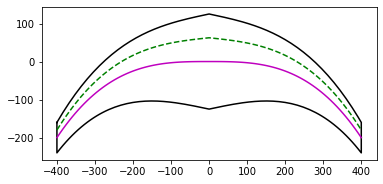

Simple wing area = 132000.0
Trapz wing area = 132000.0
Aspect ratio = 4.848484848484849
Wing lift = 741.7888295455773 Newtons
[ 380.42260652 -216.26432082    0.        ] [ 380.42260652 -150.02402665    0.        ] 0 0
40
39


In [426]:
wing1 = LiftingSurface(250, 80, 800, -200, 3, 0, 0)
wing1.generate_coords(npts=101)
wing1.plot2D()
# wing1.plot3D()
print("Simple wing area =", str(wing1.calc_simple_proj_wing_area()))
print("Trapz wing area =", str(wing1.calc_trapz_proj_wing_area()))
print("Aspect ratio =", str(wing1.calc_AR()))
print("Wing lift =", str(wing1.calc_lift(V=5, aoa=4, rho=1025)), "Newtons")

wing1.generate_LL_geom(10)
wing1.LL_seg_area
print(wing1.BVs[39].node1, wing1.BVs[39].node2, wing1.BVs[0].elmtID, wing1.BVs[0].circ)
print(len(wing1.BVs))
print(wing1.BVs[-1].elmtID)

In [ ]:
aerofoil1 = Aerofoil()
print(aerofoil1.get_cl(5))

Create class for a vortex segment? i.e. one object for each vortex?
Properties:
- Node locations (local/global?)
- ElmtID
- What elmts connected to at each end
- Type: Bound or wake
- Circulation value?
- Segment length (original/current?)